In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_roc_curve


In [2]:
df = pd.read_csv('../20220911_data.csv')
df.drop(columns=['hire_date'], inplace=True)
for var in ('gender', 'ethnicity'):
    temp = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df.drop(columns=[var], inplace=True)
    df = df.join(temp)
    

In [3]:
y = df['terminated_in_first_year']
X = df.drop(columns=['terminated_in_first_year'])


In [4]:
def apply_pca(data, cols, prop_var_explained=0.75):
    
    D = data.copy()
    
    temp = D.iloc[:, cols].values
    temp = MinMaxScaler().fit_transform(temp)

    pca = PCA(n_components=temp.shape[1])
    pca.fit(temp)

    var_explained = pca.explained_variance_ratio_.cumsum()

    components = np.argmax(var_explained >= prop_var_explained)

    temp2 = PCA(components).fit_transform(temp)
    temp2 = pd.DataFrame(temp2)
    temp2.columns = [f'pcomponent_{i}' for i in temp2.columns]
    
    return D.iloc[:, ~cols].join(temp2)

In [6]:
# cols = X.columns.str.contains('strengths|weakness|compared_to_others')
# X_with_pca = apply_pca(X, cols, 0.75)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)


In [58]:
#####################
### BOOSTING TREE ###
#####################

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
clf = AdaBoostClassifier(random_state=0, n_estimators = 1000)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.756838905775076

In [78]:
parameters = {
    'loss': ('log_loss', 'exponential'),
#     'learning_rate': np.arange(0.05, 0.31, 0.05),
    'subsample': np.arange(0.7, 1.01, 0.1),
    'n_estimators': np.arange(100, 1001, 100),
    'ccp_alpha': np.arange(0, 0.05, 0.01),
    'max_depth': np.arange(1, 6, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
}

clf = GradientBoostingClassifier(random_state=0)
cv = RandomizedSearchCV(clf, parameters, n_iter=200, n_jobs=-1)
cv.fit(X_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04]),
                                        'loss': ('log_loss', 'exponential'),
                                        'max_depth': array([1, 2, 3, 4, 5]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   verbose=5)

In [80]:
pd.DataFrame(cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_loss,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
142,0.353299,0.011498,0.003540,0.001716,0.9,100,2,2,4,log_loss,0.0,"{'subsample': 0.8999999999999999, 'n_estimator...",0.771863,0.745247,0.775665,0.760456,0.751908,0.761028,0.011525,1
28,0.845287,0.011498,0.001889,0.000935,0.7,300,5,3,5,exponential,0.01,"{'subsample': 0.7, 'n_estimators': 300, 'min_s...",0.760456,0.764259,0.779468,0.741445,0.748092,0.758744,0.013233,2
49,0.940819,0.016484,0.001764,0.000907,0.8,600,7,2,2,exponential,0.01,"{'subsample': 0.7999999999999999, 'n_estimator...",0.768061,0.764259,0.749049,0.741445,0.759542,0.756471,0.009852,3
84,0.811367,0.023409,0.002974,0.001674,0.7,400,3,4,3,exponential,0.01,"{'subsample': 0.7, 'n_estimators': 400, 'min_s...",0.752852,0.764259,0.752852,0.749049,0.755725,0.754947,0.005116,4
13,0.681284,0.019062,0.002155,0.000071,0.9,300,7,4,3,exponential,0.0,"{'subsample': 0.8999999999999999, 'n_estimator...",0.752852,0.756654,0.760456,0.756654,0.748092,0.754942,0.004185,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2.989475,0.043696,0.008905,0.002696,0.9,900,9,2,4,log_loss,0.0,"{'subsample': 0.8999999999999999, 'n_estimator...",0.741445,0.722433,0.737643,0.718631,0.717557,0.727542,0.010005,196
77,0.640606,0.012412,0.002771,0.000378,0.7,300,6,4,3,log_loss,0.0,"{'subsample': 0.7, 'n_estimators': 300, 'min_s...",0.760456,0.695817,0.745247,0.730038,0.706107,0.727533,0.023954,197
177,1.257204,0.026819,0.006283,0.002854,0.7,500,8,3,3,log_loss,0.0,"{'subsample': 0.7, 'n_estimators': 500, 'min_s...",0.749049,0.703422,0.737643,0.718631,0.717557,0.725260,0.016121,198
153,2.720206,0.051920,0.007401,0.000939,1.0,700,2,2,4,exponential,0.0,"{'subsample': 0.9999999999999999, 'n_estimator...",0.730038,0.718631,0.737643,0.695817,0.732824,0.722991,0.014956,199


In [119]:
var_imp = {k: v for k, v in zip(cv.best_estimator_.feature_names_in_, cv.best_estimator_.feature_importances_)}
var_imp = {k: v for k, v in sorted(var_imp.items(), key=lambda item: -item[1])}

var_imp


{'age_at_hire': 0.08574331880861022,
 'compared_to_others_detail': 0.05772895051169023,
 'compared_to_others_handles_stress': 0.050877131305629854,
 'compared_to_others_intelligence': 0.05054606434899463,
 'is_manager': 0.048999687929534096,
 'compared_to_others_enjoyable': 0.048365794189481046,
 'strengths_working_within_a_team': 0.04613296751185988,
 'compared_to_others_willingness_to_go_above_and_beyond_for_the_job': 0.04143311510174169,
 'compared_to_others_takes_feedback': 0.039001896583069,
 'ethnicity_Black/African American': 0.03588845535620228,
 'compared_to_others_work_quality': 0.035571745229549076,
 'compared_to_others_optimistim': 0.03494916836672122,
 'compared_to_others_communication_skills': 0.034654465232765816,
 'ethnicity_Other': 0.024334905481375173,
 'was_referral': 0.02404295667953608,
 'strengths_coachability': 0.02025179960929138,
 'strengths_patience': 0.01899776473891962,
 'ethnicity_Hispanic/Latinx': 0.018931370000236182,
 'gender_undisclosed': 0.018771770284

In [82]:
1 - y_train.mean()

0.7473363774733638

In [84]:
1 - y_test.mean()

0.7993920972644377

In [120]:
best_clf = cv.best_estimator_

print(
    'train score:', best_clf.score(X_train, y_train), '\n',
    'test score:', best_clf.score(X_test, y_test),
)

confusion_matrix(best_clf.predict(X_train), y_train)

train score: 0.9170471841704718 
 test score: 0.8267477203647416


array([[977, 104],
       [  5, 228]])

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


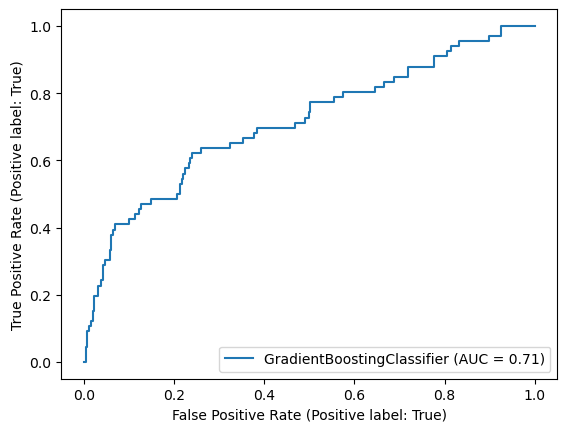

In [121]:
plot_roc_curve(best_clf, X_test, y_test)